## 1. Data Upload

In [27]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

path_csv = '.'

# Read the CSV files into pandas dataframes
input_formal_model = pd.read_csv(f"{path_csv}/formal_model.csv")

In [28]:
input_formal_model

,ID,Target,f1,f2,f3,f4,f5
0,1,1,2.8,-1.8,-2.800000,1.300000,0.4
1,2,1,2.9,-1.9,-2.900000,1.400000,0.5
2,3,1,3.0,-2.0,-3.000000,1.500000,0.6
3,4,1,3.1,-2.1,-3.100000,1.600000,0.7
4,5,1,3.2,-2.2,-3.200000,1.700000,0.8
5,6,2,-1.6,-2.5,1.500000,0.200000,0.6
6,7,2,-1.3,-2.7,1.300000,0.400000,0.8
7,8,2,-1.0,-3.0,1.500000,0.600000,1.0
8,9,2,-0.7,-3.2,1.700000,0.800000,1.2
9,10,2,-0.5,-3.5,1.900000,1.000000,1.4


## 2. Multi-dimensional scaling

In [29]:
# Extract the necessary subtables
formal_model_features = input_formal_model.drop('Target', axis=1).drop('ID', axis=1)
formal_model_with_id = input_formal_model.drop('Target', axis=1)
formal_model_id = input_formal_model['ID']
formal_model_target = input_formal_model['Target']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(formal_model_features)

# Apply MDS to reduce the dimensions to 2
mds = MDS(n_components=2, normalized_stress='auto')
X_mds = mds.fit_transform(X_scaled)

# Convert the reduced data back to a pandas DataFrame
formal_model_reduced = pd.DataFrame(X_mds, columns=["x1", "x2"])


In [30]:
# formal_model_with_id.to_csv('formal_model_with_id.csv', index=False)
# formal_model_with_id

formal_model_reduced

,x1,x2
0,-1.889093,-0.646765
1,-1.958192,-0.825344
2,-2.026464,-1.005986
3,-2.093165,-1.189116
4,-2.159505,-1.373393
5,1.945249,-0.472799
6,1.719543,-0.800894
7,1.632765,-1.231396
8,1.534206,-1.595397
9,1.571255,-2.027391


## 3. Visual analytics

In [31]:
def interpolate_coordinates(x_1, x_n, n):
    """
    This function calculates the values of the interpolate_coordinates
    of a line based on its first and last coordinates.
    :param x_1:
    :param x_n:
    :param n:
    :return:
    """
    # Ensure n is greater than 1 to avoid division by zero
    if n <= 1:
        raise ValueError("n must be greater than 1 to calculate intermediate points.")

    # List to hold all the coordinates including the first and the last
    inter_coordinates = []

    # Calculate each intermediate coordinate
    for iter in range(0, n):
        x_iter = x_1 + ((x_n - x_1) * iter) / (n - 1)
        inter_coordinates.append(x_iter)

    return inter_coordinates


In [32]:
x_1_first = 3
x_1_last = -2
x_2_first = 1
x_2_last = 0
num_points = 5

x_1_inter_coordinates = interpolate_coordinates(x_1_first, x_1_last, num_points)
x_2_inter_coordinates = interpolate_coordinates(x_2_first, x_2_last, num_points)
# print(x_1_inter_coordinates)
# print(x_2_inter_coordinates)

# Create a DataFrame from the coordinates
coordinates_df = pd.DataFrame({'x1': x_1_inter_coordinates, 'x2': x_2_inter_coordinates})
coordinates_df


,x1,x2
0,3.00,1.00
1,1.75,0.75
2,0.50,0.50
3,-0.75,0.25
4,-2.00,0.00


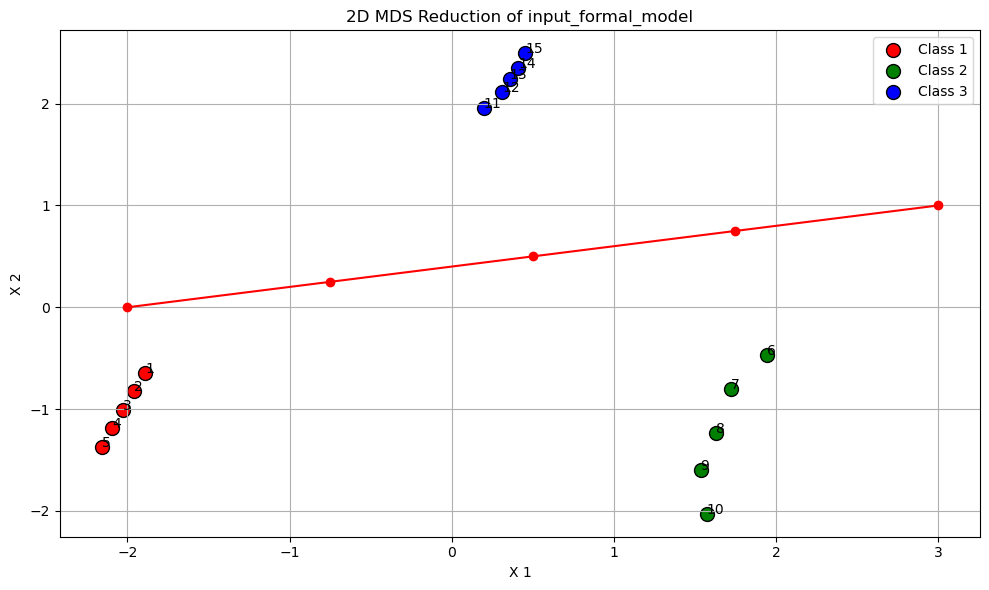

In [33]:
import matplotlib.pyplot as plt

# Include class colors and a legend
colors = {1: 'red', 2: 'green', 3: 'blue'}  # Assigning colors to each class

plt.figure(figsize=(10, 6))

# Iterate over each class and plot each class with a different color
for cls in input_formal_model['Target'].unique():
    cls_data = formal_model_reduced[input_formal_model['Target'] == cls]
    plt.scatter(cls_data['x1'], cls_data['x2'], s=100, edgecolor='k', color=colors[cls], label=f'Class {cls}')

# Annotate points with ID
for i, txt in enumerate(input_formal_model['ID']):
    plt.annotate(txt, (formal_model_reduced['x1'].iloc[i], formal_model_reduced['x2'].iloc[i]), fontsize=10)

# Draw the separating line
line_x1 = coordinates_df['x1'].tolist()
line_x2 = coordinates_df['x2'].tolist()
plt.plot(line_x1, line_x2, 'ro-')

plt.xlabel("X 1")
plt.ylabel("X 2")
plt.title(f"2D MDS Reduction of {'input_formal_model'}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 4. Calculate Transition Matrix

### 3.1. Singular Value Decomposition (SVD)

In [34]:
# Receive values from the matrix A DataFrame 
formal_model_reduced_values = formal_model_reduced.values

# Calculate SVD
U, s, Vt = np.linalg.svd(formal_model_reduced_values)

# Construct the full diagonal matrix
S = np.zeros(formal_model_reduced_values.shape)
for i in range(min(formal_model_reduced_values.shape)):
    S[i, i] = s[i]

# print("U:\n", U)
# print("\nS:\n", S)
# print("\nVt:\n", Vt)


### 3.2. Create the reconstructed matrix of SVD

In [35]:
# Recompute the original matrix using U, S, and Vt
reconstructed_matrix = U.dot(S.dot(Vt))

# Convert the reconstructed matrix to a pandas DataFrame, if desired
reconstructed_df = pd.DataFrame(reconstructed_matrix)


In [36]:
reconstructed_df

,0,1
0,-1.889093,-0.646765
1,-1.958192,-0.825344
2,-2.026464,-1.005986
3,-2.093165,-1.189116
4,-2.159505,-1.373393
5,1.945249,-0.472799
6,1.719543,-0.800894
7,1.632765,-1.231396
8,1.534206,-1.595397
9,1.571255,-2.027391


In [37]:
formal_model_reduced

,x1,x2
0,-1.889093,-0.646765
1,-1.958192,-0.825344
2,-2.026464,-1.005986
3,-2.093165,-1.189116
4,-2.159505,-1.373393
5,1.945249,-0.472799
6,1.719543,-0.800894
7,1.632765,-1.231396
8,1.534206,-1.595397
9,1.571255,-2.027391


### 3.3. Calculate the generalized inverse of input matrix

In [38]:
# Calculate the generalized (Moore-Penrose) inverse
formal_model_reduced_pinv = np.linalg.pinv(formal_model_reduced_values)

# Convert to a pandas DataFrame
formal_model_reduced_pinv_df = pd.DataFrame(formal_model_reduced_pinv)

In [39]:
formal_model_reduced_pinv_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.052038,-0.053457,-0.054846,-0.056183,-0.057505,0.057143,0.051710,0.050572,0.048889,0.051299,-0.000506,0.002256,0.003188,0.004340,0.005139
1,-0.010663,-0.015021,-0.019435,-0.023917,-0.028430,-0.018190,-0.025888,-0.036644,-0.045660,-0.056841,0.049573,0.053180,0.056440,0.059019,0.062475


### 3.4. Calculate transition matrix T

In [40]:
transition_matrix_T = formal_model_reduced_pinv_df.dot(formal_model_features)

In [41]:
transition_matrix_T

,f1,f2,f3,f4,f5
0,-1.079471,-0.233838,1.245284,-0.266232,0.046346
1,0.140466,0.492208,0.226618,-0.399015,-1.110787


## 4. Create Hyperplane

In [42]:
coordinates_hyperplane_df = coordinates_df.values @ transition_matrix_T.values

In [43]:
coordinates_hyperplane_df

array([[-3.09794762, -0.20930596,  3.96246933, -1.19771061, -0.97174896],
       [-1.78372509, -0.04006044,  2.34921008, -0.76516698, -0.75198478],
       [-0.46950257,  0.12918507,  0.73595082, -0.33262335, -0.53222059],
       [ 0.84471995,  0.29843059, -0.87730843,  0.09992028, -0.31245641],
       [ 2.15894247,  0.4676761 , -2.49056769,  0.53246391, -0.09269222]])

In [44]:
# Adding a new column with all values set to 1
new_column = np.ones((coordinates_hyperplane_df.shape[0], 1))
feature_vector_inverse = np.hstack((new_column, coordinates_hyperplane_df))

feature_vector_inverse

array([[ 1.        , -3.09794762, -0.20930596,  3.96246933, -1.19771061,
        -0.97174896],
       [ 1.        , -1.78372509, -0.04006044,  2.34921008, -0.76516698,
        -0.75198478],
       [ 1.        , -0.46950257,  0.12918507,  0.73595082, -0.33262335,
        -0.53222059],
       [ 1.        ,  0.84471995,  0.29843059, -0.87730843,  0.09992028,
        -0.31245641],
       [ 1.        ,  2.15894247,  0.4676761 , -2.49056769,  0.53246391,
        -0.09269222]])

In [45]:
# Optimization criteria function
def optimization_criteria(W, X):
    """
    Inverse optimization function
    :param W: 
    :param X: 
    :return: 
    """
    return np.sum(np.abs(X.dot(W.T)))

# Initial guess (starting point for the optimization algorithm)
weights_inverse_initial = np.zeros(feature_vector_inverse.shape[1])

# Bounds for W (setting it between -1 and 1)
bounds = [(-1, 1) for _ in range(feature_vector_inverse.shape[1])]

# The actual optimization
res = minimize(
    optimization_criteria,
    weights_inverse_initial,
    args=(feature_vector_inverse,),
    method='SLSQP',
    bounds=bounds,
    options={'disp': True}
)

# Checking if the optimization was successful
if res.success:
    # Extract the weights into a DataFrame
    weights_inverse_output = pd.DataFrame(res.x, index=[f'w{i}' for i in range(len(res.x))], columns=['weight'])

    print("Optimization was successful. The weights are:")
    print(weights_inverse_output)

    # Output the value of the optimization criteria
    print("\nValue of the optimization criteria (objective function value):", res.fun)
else:
    print("Optimization failed.")

# Checking for convergence
print("\nConvergence status:", res.message)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.529197813982601e-07
            Iterations: 12
            Function evaluations: 116
            Gradient evaluations: 12
Optimization was successful. The weights are:
      weight
w0 -0.000205
w1 -0.000291
w2  0.000043
w3 -0.000440
w4 -0.000596
w5 -0.000355

Value of the optimization criteria (objective function value): 8.529197813982601e-07

Convergence status: Optimization terminated successfully


In [46]:
weights_inverse_output

,weight
w0,-0.000205
w1,-0.000291
w2,0.000043
w3,-0.000440
w4,-0.000596
w5,-0.000355


In [47]:
# Reorder the weight vector so that w0 is at the end.
weights_df_reordered = pd.concat([weights_inverse_output.iloc[1:], weights_inverse_output.iloc[0:1]]).reset_index(drop=True)

# Show the modified DataFrame
weights_df_reordered


,weight
0,-0.000291
1,0.000043
2,-0.000440
3,-0.000596
4,-0.000355
5,-0.000205


In [48]:
# Create a new DataFrame with an additional column
new_formal_model_features = formal_model_features.copy()
new_formal_model_features['f0'] = 1
new_formal_model_features


,f1,f2,f3,f4,f5,f0
0,2.8,-1.8,-2.800000,1.300000,0.4,1
1,2.9,-1.9,-2.900000,1.400000,0.5,1
2,3.0,-2.0,-3.000000,1.500000,0.6,1
3,3.1,-2.1,-3.100000,1.600000,0.7,1
4,3.2,-2.2,-3.200000,1.700000,0.8,1
5,-1.6,-2.5,1.500000,0.200000,0.6,1
6,-1.3,-2.7,1.300000,0.400000,0.8,1
7,-1.0,-3.0,1.500000,0.600000,1.0,1
8,-0.7,-3.2,1.700000,0.800000,1.2,1
9,-0.5,-3.5,1.900000,1.000000,1.4,1


In [49]:
# # Multiply the features by the weights
my_result = new_formal_model_features.mul(weights_df_reordered['weight'].values, axis=1)

# Sum along the rows to get the final single column for predictions
my_predictions = my_result.sum(axis=1)

# Convert the series to a data frame
my_predictions_df = my_predictions.to_frame(name='Prediction')

In [50]:
my_predictions_df

,Prediction
0,-0.000780
1,-0.000865
2,-0.000949
3,-0.001034
4,-0.001118
5,-0.000840
6,-0.001038
7,-0.001417
8,-0.001791
9,-0.002140


In [51]:
my_predictions_df = pd.concat([my_predictions_df, formal_model_target], axis=1)


In [52]:
my_predictions_df

,Prediction,Target
0,-0.000780,1
1,-0.000865,1
2,-0.000949,1
3,-0.001034,1
4,-0.001118,1
5,-0.000840,2
6,-0.001038,2
7,-0.001417,2
8,-0.001791,2
9,-0.002140,2
